# 1. Stating and refining the question.

A suitable question is “What is the average duration of a medical rep's visit to a doctor for a specific product? (Descriptive)”

Let’s apply the epicycle:
- Expectations: The question is answerable and useful
- Collection: Looking at the dataset and collecting information about the company objectives.
    - conclusion: indeed time spent in the visit can be a good estimate of how good the rep can deliver the information, using the duration for every visit in the dataset we can get the average
- Match: Idead expectations and data collection match.

# 2. Exploratory data analysis.

Let’s apply the epicycle:
- Expectations: we should have a dataset of representatives visits with the duration of the visit and the product, we should not display any sensitive information the users, we should have missing values as the app force the user
to enter the complete information, however their could be some outliers due to 
users mistakes.
- Collection: Exploring and vislualizing the dataset, looking for missing values and outliers, and also looking for any sensitive information that should not be displayed.
    - conclusion: indeed we have a dataset of representatives visits with the duration of the visit and the product, we carefully drop any sensitive information before beginning the analysis, we have no missing values, however we have some outliers that we should take care of.
- Match: Idead expectations and data collection match.

##### Imports

In [2]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

##### First let's connect to mongoDB.

In [3]:
# Load environment variables from .env file
load_dotenv()

# Retrieve the connection string from the environment variables
connection_string = os.getenv("CONNECTION_STRING")

# Connect to the MongoDB server
client = MongoClient(connection_string)

# Connect to the database
db = client['tacitapp']

# Connect to the collection
visits = db['visits']

##### Get the data we need.


In [4]:
# Define the pipeline
pipeline = [
    {
        '$unwind': '$calls'
    }, 
    {
        '$project': {
            '_id': 0, 
            'representative_id': '$user.id', 
            'representative_name': '$user.name', 
            'product_id': '$calls.product.id', 
            'product_name': '$calls.product.name', 
            'duration': '$calls.duration'
        }
    }
]

In [5]:
# Execute the pipeline
result = visits.aggregate(pipeline)

# Store the result in a dataframe
df = pd.DataFrame(result)

##### Privacy note:
For data sensetive reasons, we will drop the representative name, and product name columns

In [6]:
# View columns
print(df.columns)
# Drop columns
df.drop(['representative_name', 'product_name'], axis=1, inplace=True)
# View columns
print(df.columns)


Index(['representative_id', 'representative_name', 'product_id',
       'product_name', 'duration'],
      dtype='object')
Index(['representative_id', 'product_id', 'duration'], dtype='object')


##### Handle missing values
we can see that there are no missing values in the dataset.
and that is mainly because the system does not allow the rep to submit the visit if he did not fill all the required fields.

In [7]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
representative_id,0,0.0
product_id,0,0.0
duration,0,0.0


##### some statistics about the data

In [8]:
# Display the first 5 rows
df.head()

,representative_id,product_id,duration
0,603a2ef7d1fce046a5e63f8a,5ed23cd5ea976a0017a6b40b,114
1,603a2ef7d1fce046a5e63f8a,5ed23cd5ea976a0017a6b40b,71
2,603a2ef7d1fce046a5e63f8a,5ef3273db5606802f6c2a038,66
3,5d665baa0c15a90015e6e925,5d6bb714f4c94d001500c3b7,97
4,5d665baa0c15a90015e6e925,5d6bb295f4c94d001500c383,47


In [9]:
# descriptive statistics summary
df.describe()

,duration
count,1.205210e+05
mean,2.288388e+03
std,6.607555e+04
min,-1.603604e+06
25%,3.100000e+01
50%,1.050000e+02
75%,2.140000e+02
max,3.631316e+06


we notice that the duration column has a minimum value less than 0, which is not possible
let's check how many rows have a negative duration

In [10]:
print('Number of rows with negative duration: ', len(df[df['duration'] < 0]))
print('Total number of rows: ', len(df))

Number of rows with negative duration:  21
Total number of rows:  120521


we notice that the number of rows with negative duration is very small compared to the total number of rows
so we will drop these rows since they will not affect our analysis

In [11]:
df = df[df['duration'] >= 0]

In [12]:
# descriptive statistics summary
df.describe()

,duration
count,1.205000e+05
mean,2.426987e+03
std,6.477871e+04
min,0.000000e+00
25%,3.100000e+01
50%,1.050000e+02
75%,2.140000e+02
max,3.631316e+06


##### outliers

C:\Users\batyo\AppData\Local\Temp\ipykernel_25280\3577618247.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration'])


<Axes: xlabel='duration', ylabel='Density'>

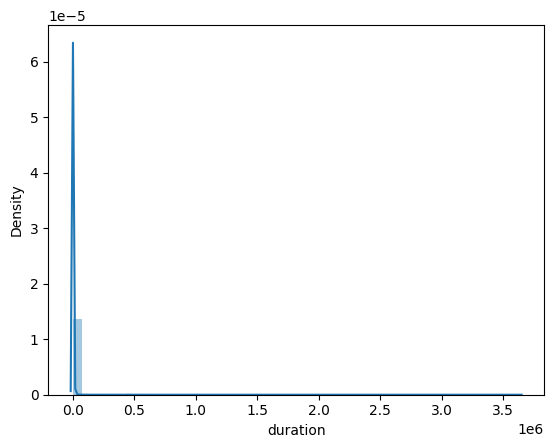

In [13]:
#histogram
sns.distplot(df['duration'])

In [14]:
#skewness and kurtosis
print("Skewness: %f" % df['duration'].skew())
print("Kurtosis: %f" % df['duration'].kurt())

Skewness: 40.422578
Kurtosis: 1842.635290


from histogram, skewness and kurtosis, we notice that: <br>
the distribution is highly skewed to the right. It indicates that there are 
a large number of extreme values on the right side of the distribution, with 
the majority of values concentrated on the left side. <br><br>
the distribution has heavy tails and a very peaked or sharp peak compared 
to a normal distribution. It suggests the presence of many outliers or 
extreme values in the dataset

<Axes: xlabel='duration'>

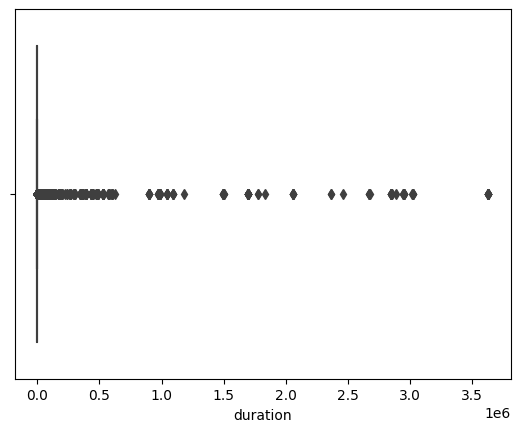

In [15]:
# let's build a boxplot to check for outliers
sns.boxplot(x=df['duration'])

(-0.5, 205.5, 0.0, 800000.0)

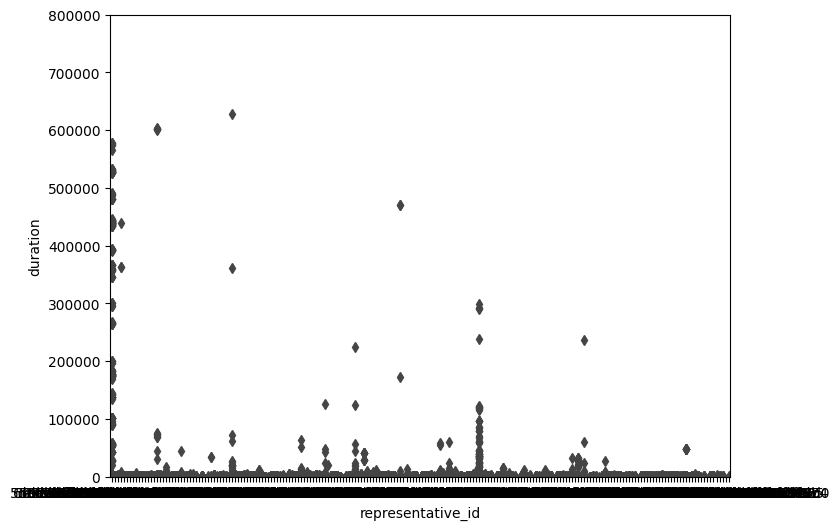

In [16]:
#box plot representative_id/duration
var = 'representative_id'
data = pd.concat([df['duration'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="duration", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 103.5, 0.0, 800000.0)

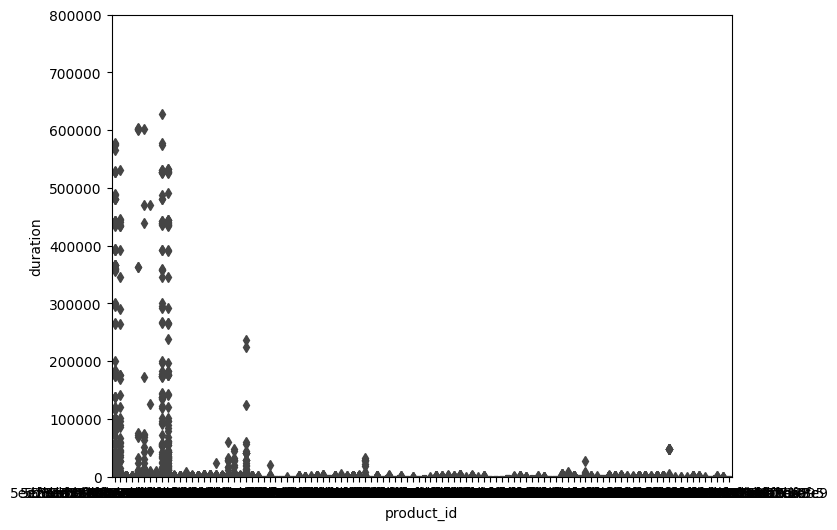

In [17]:
#box plot representative_id/duration
var = 'product_id'
data = pd.concat([df['duration'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="duration", data=data)
fig.axis(ymin=0, ymax=800000)

Indeed we seem to have some outliers, let's use the IQR method to detect and remove them

In [18]:
# Calculate the interquartile range (IQR)
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove the outliers from the DataFrame
df_outliers_removed = df[(df['duration'] >= lower_bound) & (df['duration'] <= upper_bound)]
# Remove the outliers from the DataFrame
outliers = df[(df['duration'] < lower_bound) | (df['duration'] > upper_bound)]

print("Original DataFrame:")
print(df)
print("\nDataFrame with outliers removed:")
print(df_outliers_removed)

Original DataFrame:
               representative_id                product_id  duration
0       603a2ef7d1fce046a5e63f8a  5ed23cd5ea976a0017a6b40b       114
1       603a2ef7d1fce046a5e63f8a  5ed23cd5ea976a0017a6b40b        71
2       603a2ef7d1fce046a5e63f8a  5ef3273db5606802f6c2a038        66
3       5d665baa0c15a90015e6e925  5d6bb714f4c94d001500c3b7        97
4       5d665baa0c15a90015e6e925  5d6bb295f4c94d001500c383        47
...                          ...                       ...       ...
120516  5da46d08565e290015188598  627c1ac7fb39d974092ce101       100
120517  5da46d08565e290015188598  627c1ac7fb39d974092ce101       116
120518  5da46d08565e290015188598  627c1ac7fb39d974092ce101       101
120519  5da46d08565e290015188598  627c19d1fb39d974092cdefd        79
120520  5da46d08565e290015188598  62b0db56a7da56342e17b3f8       276

[120500 rows x 3 columns]

DataFrame with outliers removed:
               representative_id                product_id  duration
0       603a2ef7d1fce0

In [19]:
# let's see the removed outliers sorted by duration
outliers.sort_values(by='duration')

,representative_id,product_id,duration
54630,61546abd2e93f37d107a3cb2,5ee53c81c46d6372415cf1ca,489
106840,5da46ce7565e290015188597,627c1a5ffb39d974092ce0d6,489
117490,63c9044a0744557bbf6f34c2,63c85cc3d49e5942799ed525,489
23789,628b3c337ee2c0232015abd3,601fc06c1505c427e08e1ff7,489
86734,602cec74d1fce046a5d0129f,5cacafaf848764059ca91430,489
...,...,...,...
42220,61c9c6d1f112877cf6614ad6,5ee5320cc46d6372415cf13e,3629180
42219,61c9c6d1f112877cf6614ad6,5ee53c81c46d6372415cf1ca,3629244
42218,61c9c6d1f112877cf6614ad6,5ed2582b6adb110017d783a6,3629451
42217,61c9c6d1f112877cf6614ad6,5ee5320cc46d6372415cf13e,3629486


<Axes: xlabel='duration'>

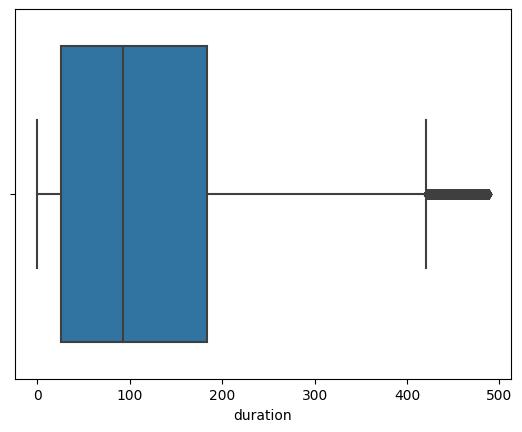

In [20]:
# Let's build a boxplot to check for outliers after removing the outliers
sns.boxplot(x=df_outliers_removed['duration'])

C:\Users\batyo\AppData\Local\Temp\ipykernel_25280\3409099220.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_outliers_removed['duration'])


<Axes: xlabel='duration', ylabel='Density'>

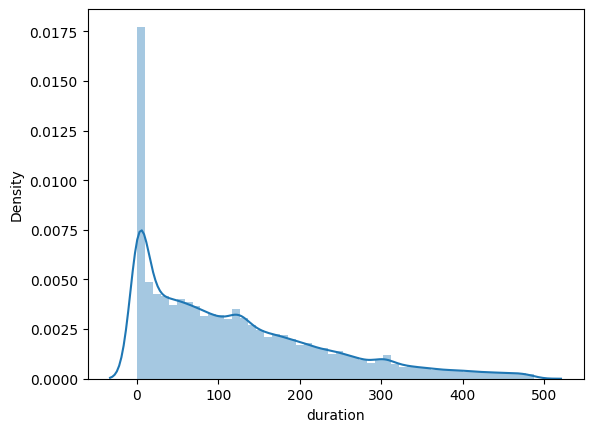

In [21]:
#histogram
sns.distplot(df_outliers_removed['duration'])

In [22]:
#skewness and kurtosis
print("Skewness: %f" % df_outliers_removed['duration'].skew())
print("Kurtosis: %f" % df_outliers_removed['duration'].kurt())

Skewness: 1.030803
Kurtosis: 0.450544


Indeed the number of outliers is very small compared to the total number of rows, so we will drop them

and the distribution is now more reasonable

In [23]:
df = df_outliers_removed

# 3. Build a model.

however we don't need a model to answer our question, we can simply calculate the average of the duration column so we will do that

Applying the epicycle:
- Expectations: After preprocessing and visualizing the data, we should be able to answer the question by grouping on the representative and product columns and calculating the average of the duration column.
- Collection: Indeed we managed to answer the question.
- Match: Indeed expectations and data collection match.

In [24]:
# Calculate the average duration of representative for each product
average_duration = df.groupby(['representative_id', 'product_id'])['duration'].mean()
print(average_duration)

representative_id         product_id              
5d665baa0c15a90015e6e925  5d6bb295f4c94d001500c383     58.247619
                          5d6bb714f4c94d001500c3b7     59.000000
                          5d6bbb4bf4c94d001500c3ee     48.895833
                          5d6bc198f4c94d001500c470     56.183206
                          5ec05e820989f500172729bb     50.752475
                                                         ...    
6436a685bb05fa24a6e7f685  61101c47481d0d73c214e9a3      3.500000
6436a6c8bb05fa24a6e7f68d  5d6bbb4bf4c94d001500c3ee     28.333333
                          5feb451646a1c87ac1960bcf     72.800000
                          601fceaa1505c427e08e20c7    124.300000
                          61101c47481d0d73c214e9a3     12.000000
Name: duration, Length: 1009, dtype: float64


In [25]:
# Convert the result to a DataFrame for easy plotting
df_average_duration = average_duration.reset_index()
print(df_average_duration)

             representative_id                product_id    duration
0     5d665baa0c15a90015e6e925  5d6bb295f4c94d001500c383   58.247619
1     5d665baa0c15a90015e6e925  5d6bb714f4c94d001500c3b7   59.000000
2     5d665baa0c15a90015e6e925  5d6bbb4bf4c94d001500c3ee   48.895833
3     5d665baa0c15a90015e6e925  5d6bc198f4c94d001500c470   56.183206
4     5d665baa0c15a90015e6e925  5ec05e820989f500172729bb   50.752475
...                        ...                       ...         ...
1004  6436a685bb05fa24a6e7f685  61101c47481d0d73c214e9a3    3.500000
1005  6436a6c8bb05fa24a6e7f68d  5d6bbb4bf4c94d001500c3ee   28.333333
1006  6436a6c8bb05fa24a6e7f68d  5feb451646a1c87ac1960bcf   72.800000
1007  6436a6c8bb05fa24a6e7f68d  601fceaa1505c427e08e20c7  124.300000
1008  6436a6c8bb05fa24a6e7f68d  61101c47481d0d73c214e9a3   12.000000

[1009 rows x 3 columns]


# 4. Interpret the results.
Let’s apply the epicycle:
- Expectations: Useful insights and intrpretations, we should be able to indicate the distribution of the duration for each product, hence can be used to indicate the preformance of the rep for each product.
- Collection: we can see that the average duration of each product varies from a representative to another and some durations deviate from the average by a large amount, so we can conclude that which means that some representatives are better than others in delivering the information.
- Match: Indeed expectations and data collection match.

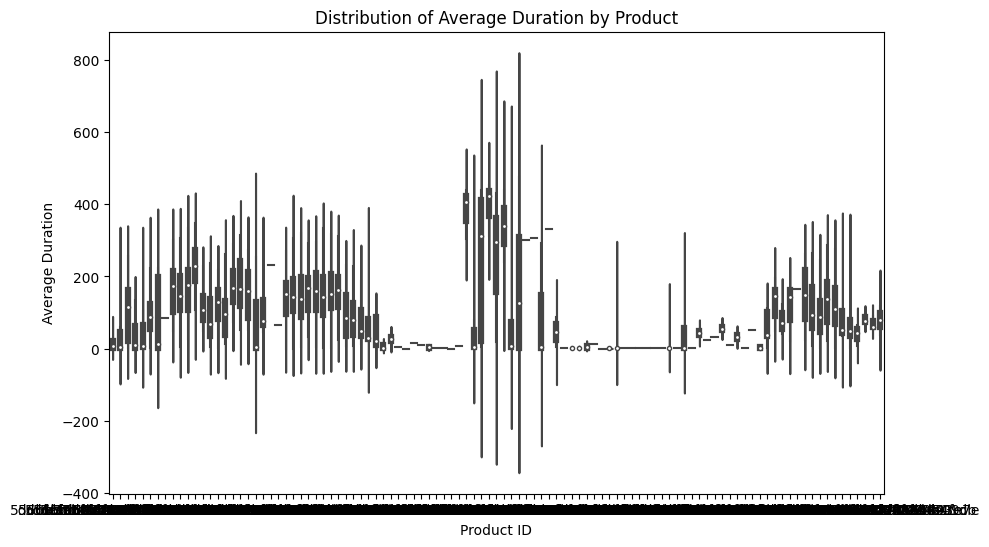

In [26]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_average_duration, x='product_id', y='duration')
plt.xlabel('Product ID')
plt.ylabel('Average Duration')
plt.title('Distribution of Average Duration by Product')
plt.show()

we can see that the average duration of each product varies from a representative to another and some durations deviate from the average by a large amount.

So we can conclude that which means that some representatives are better than others in delivering the information.

# 5. Communicate the results.
Let’s apply the epicycle:
- Expectations: The results should be communicated in a clear and understandable way.
- Collection: Indeed we used boxplots to show the distribution of the duration for each product.
- Match: Indeed expectations and data collection match.

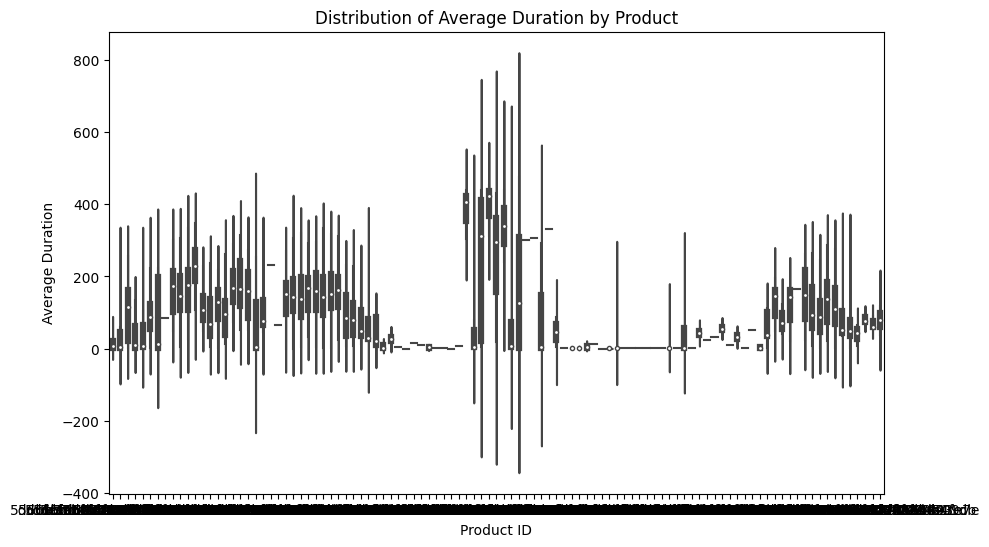

In [27]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_average_duration, x='product_id', y='duration')
plt.xlabel('Product ID')
plt.ylabel('Average Duration')
plt.title('Distribution of Average Duration by Product')
plt.show()

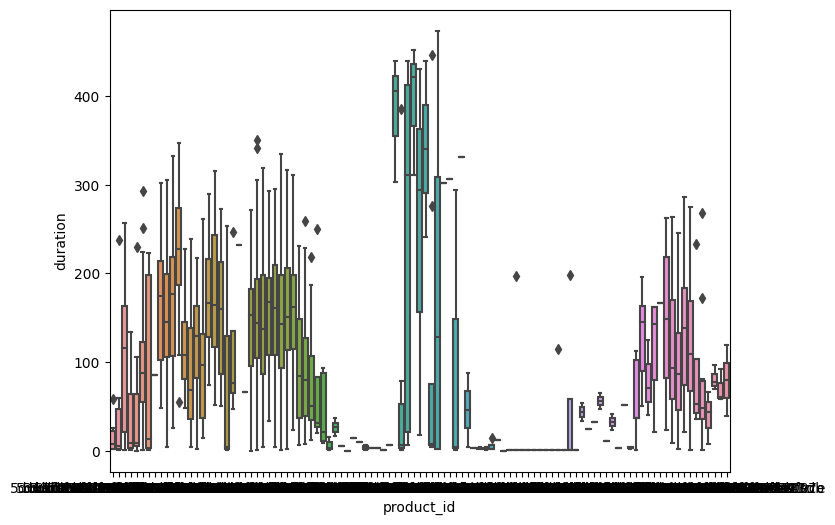

In [34]:
# box plot product_id/average_duration
var = 'product_id'
data = pd.concat([df_average_duration['duration'], df_average_duration[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="duration", data=data)

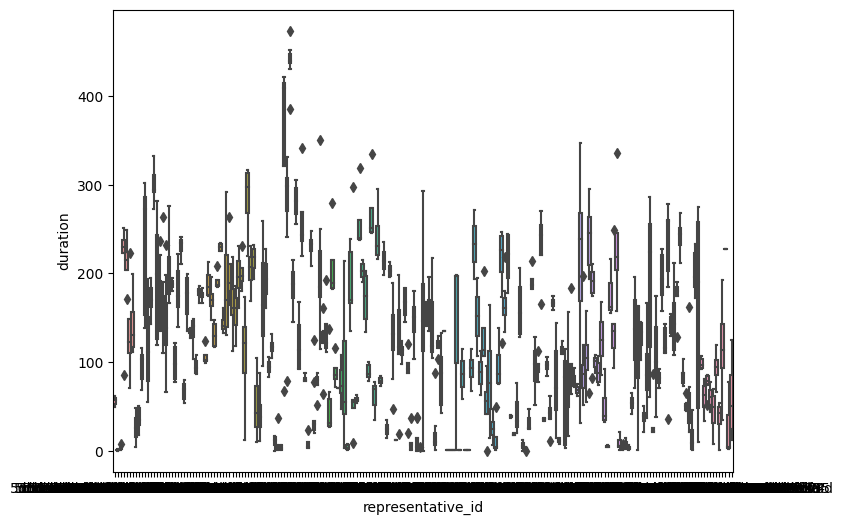

In [35]:
# box plot representative_id/average_duration
var = 'representative_id'
data = pd.concat([df_average_duration['duration'], df_average_duration[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="duration", data=data)